# Baseline Results

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, TimeDistributed, Conv1D, BatchNormalization, MaxPooling1D, Bidirectional, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.initializers import Constant
from keras.layers.advanced_activations import PReLU

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, get_class_names, load_fusioned_dataset

In [2]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
)

In [3]:
epochs, batch_size = 25, 32
kf = KFold(n_splits=3, shuffle=True, random_state=48)

cnn_auc = []
rnn_auc = []

## 1. Unimodal Body Modality (Skeleton)

### Dataset

In [4]:
X_train, X_test, y_train, y_test = load_dataset('skeleton')
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(812, 1, 350, 35) (812, 7)
(245, 1, 350, 35) (245, 7)


In [5]:
classes = get_class_names('skeleton')
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

No Pain               403
LowerBody Mild        164
LowerBody Moderate    103
UpperBody Mild         75
UpperBody Moderate     64
UpperBody Severe        2
LowerBody Severe        1
dtype: int64

In [6]:
nopain, lbmild, lbmod, ubmild, ubmod, ubsevere, lbsevere = np.sum(y, axis=0)
total = nopain + ubmild + lbmod + lbmild + ubmod + ubsevere + lbsevere

weight_for_lbmild = (1 / lbmild) * (total / 2.0)
weight_for_lbmod = (1 / lbmod) * (total / 2.0)
weight_for_nopain = (1 / nopain) * (total / 2.0)
weight_for_ubmild = (1 / ubmild) * (total / 2.0)
weight_for_ubmod = (1 / ubmod) * (total / 2.0)
weight_for_lbsevere = (1 / lbsevere) * (total / 2.0)
weight_for_ubsevere = (1 / ubsevere) * (total / 2.0)

class_weight = {0: weight_for_nopain, 1: weight_for_lbmild, 2: weight_for_lbmod, 3: weight_for_ubmild, 4: weight_for_ubmod, 5: weight_for_ubsevere, 6: weight_for_lbsevere}

print('Weight for class "No Pain": {:.2f}'.format(weight_for_nopain))
print('Weight for class "Lower Body Mild Pain": {:.2f}'.format(weight_for_lbmild))
print('Weight for class "Lower Body Moderate Pain": {:.2f}'.format(weight_for_lbmod))
print('Weight for class "Upper Body Mild Pain": {:.2f}'.format(weight_for_ubmild))
print('Weight for class "Upper Body Moderate Pain": {:.2f}'.format(weight_for_ubmod))
print('Weight for class "Upper Body Severe Pain": {:.2f}'.format(weight_for_ubsevere))
print('Weight for class "Lower Body Severe Pain": {:.2f}'.format(weight_for_lbsevere))

Weight for class "No Pain": 2.48
Weight for class "Lower Body Mild Pain": 3.94
Weight for class "Lower Body Moderate Pain": 406.00
Weight for class "Upper Body Mild Pain": 1.01
Weight for class "Upper Body Moderate Pain": 5.41
Weight for class "Upper Body Severe Pain": 6.34
Weight for class "Lower Body Severe Pain": 203.00


### CNN + Bidirectional LSTM

In [7]:
class CNNLSTM():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=448, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(128, activation='relu'))(flatten)
        dense = Dense(448, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 12s - loss: 241.1789 - accuracy: 0.2292 - auc: 0.5568 - precision: 0.2292 - recall: 0.2292 - f1_score: 0.1368 - val_loss: 73.1366 - val_accuracy: 0.0923 - val_auc: 0.4705 - val_precision: 0.0923 - val_recall: 0.0923 - val_f1_score: 0.0241 - 12s/epoch - 706ms/step
Epoch 2/25
17/17 - 7s - loss: 136.3296 - accuracy: 0.1238 - auc: 0.4846 - precision: 0.1241 - recall: 0.1238 - f1_score: 0.0962 - val_loss: 79.7617 - val_accuracy: 0.0923 - val_auc: 0.4705 - val_precision: 0.0923 - val_recall: 0.0923 - val_f1_score: 0.0241 - 7s/epoch - 416ms/step
Epoch 3/25
17/17 - 7s - loss: 171.0044 - accuracy: 0.1996 - auc: 0.5481 - precision: 0.1996 - recall: 0.1996 - f1_score: 0.1079 - val_loss: 24.9686 - val_accuracy: 0.4982 - val_auc: 0.7336 - val_precision: 0.4982 - val_recall: 0.4982 - val_f1_score: 0.1084 - 7s/epoch - 411ms/step
Epoch 4/25
17/17 - 7s - loss: 121.5467 - accuracy: 0.2144 - auc: 0.5544 - precision: 0.2148 - recall: 0.2144 - f1_score: 0.1339 - val_loss: 22.8896 - val_a

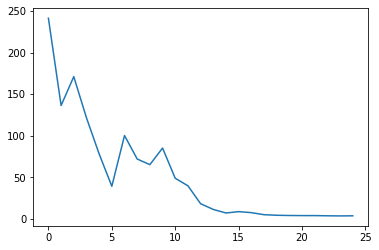

Epoch 1/25
17/17 - 10s - loss: 664.6330 - accuracy: 0.1220 - auc_1: 0.4888 - precision_1: 0.1220 - recall_1: 0.1220 - f1_score: 0.1019 - val_loss: 36.8725 - val_accuracy: 0.0701 - val_auc_1: 0.4576 - val_precision_1: 0.0701 - val_recall_1: 0.0701 - val_f1_score: 0.0187 - 10s/epoch - 573ms/step
Epoch 2/25
17/17 - 7s - loss: 156.7113 - accuracy: 0.1645 - auc_1: 0.5243 - precision_1: 0.1654 - recall_1: 0.1645 - f1_score: 0.1090 - val_loss: 12.4142 - val_accuracy: 0.3506 - val_auc_1: 0.6993 - val_precision_1: 0.3506 - val_recall_1: 0.3506 - val_f1_score: 0.1132 - 7s/epoch - 423ms/step
Epoch 3/25
17/17 - 7s - loss: 117.2656 - accuracy: 0.2070 - auc_1: 0.5762 - precision_1: 0.2079 - recall_1: 0.2033 - f1_score: 0.0999 - val_loss: 36.9256 - val_accuracy: 0.4760 - val_auc_1: 0.6762 - val_precision_1: 0.4760 - val_recall_1: 0.4760 - val_f1_score: 0.0921 - 7s/epoch - 405ms/step
Epoch 4/25
17/17 - 7s - loss: 200.3867 - accuracy: 0.0961 - auc_1: 0.4577 - precision_1: 0.0961 - recall_1: 0.0961 - f1

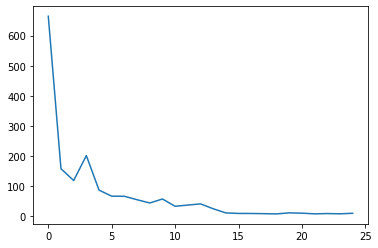

Epoch 1/25
17/17 - 13s - loss: 467.5973 - accuracy: 0.2122 - auc_2: 0.5458 - precision_2: 0.2122 - recall_2: 0.2122 - f1_score: 0.1218 - val_loss: 36.7339 - val_accuracy: 0.0778 - val_auc_2: 0.4610 - val_precision_2: 0.0778 - val_recall_2: 0.0778 - val_f1_score: 0.0206 - 13s/epoch - 762ms/step
Epoch 2/25
17/17 - 8s - loss: 201.8538 - accuracy: 0.1236 - auc_2: 0.5038 - precision_2: 0.1220 - recall_2: 0.1199 - f1_score: 0.0719 - val_loss: 5.5464 - val_accuracy: 0.0741 - val_auc_2: 0.4732 - val_precision_2: 0.0736 - val_recall_2: 0.0704 - val_f1_score: 0.0362 - 8s/epoch - 443ms/step
Epoch 3/25
17/17 - 7s - loss: 33.9175 - accuracy: 0.0443 - auc_2: 0.4736 - precision_2: 0.0898 - recall_2: 0.0424 - f1_score: 0.0266 - val_loss: 1.9481 - val_accuracy: 0.1963 - val_auc_2: 0.5006 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.0476 - 7s/epoch - 420ms/step
Epoch 4/25
17/17 - 7s - loss: 7.9684 - accuracy: 0.1716 - auc_2: 0.5092 - precision_2: 0.2000 - recall_2: 0.0055 -

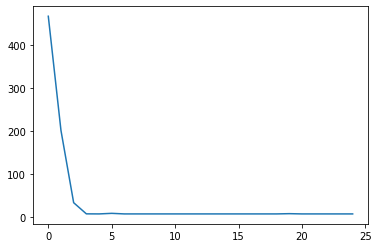

In [8]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_multiclass_body_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_multiclass_body_model.train(X_train, y_train, X_val, y_val, epochs, batch_size, class_weight)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on holdout set

In [9]:
y_pred = cnnlstm_multiclass_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_multiclass_body_model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 0.41% 
Balanced Accuracy: 14.29% 
ROC/AUC: 0.42 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.00


### RCNN

In [10]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=448, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(448, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results
    
    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 7s - loss: 50.2508 - accuracy: 0.2754 - auc_3: 0.6139 - precision_3: 0.2840 - recall_3: 0.2662 - f1_score: 0.1683 - val_loss: 87.5957 - val_accuracy: 0.1993 - val_auc_3: 0.5329 - val_precision_3: 0.1993 - val_recall_3: 0.1993 - val_f1_score: 0.0475 - 7s/epoch - 407ms/step
Epoch 2/25
17/17 - 5s - loss: 23.5554 - accuracy: 0.2606 - auc_3: 0.6127 - precision_3: 0.2747 - recall_3: 0.2514 - f1_score: 0.1669 - val_loss: 60.9605 - val_accuracy: 0.1107 - val_auc_3: 0.4767 - val_precision_3: 0.1111 - val_recall_3: 0.1107 - val_f1_score: 0.0567 - 5s/epoch - 306ms/step
Epoch 3/25
17/17 - 5s - loss: 11.9638 - accuracy: 0.2976 - auc_3: 0.6830 - precision_3: 0.3072 - recall_3: 0.2828 - f1_score: 0.2196 - val_loss: 59.6272 - val_accuracy: 0.1070 - val_auc_3: 0.4788 - val_precision_3: 0.1070 - val_recall_3: 0.1070 - val_f1_score: 0.0277 - 5s/epoch - 313ms/step
Epoch 4/25
17/17 - 5s - loss: 8.1886 - accuracy: 0.3808 - auc_3: 0.7690 - precision_3: 0.3988 - recall_3: 0.3567 - f1_score:

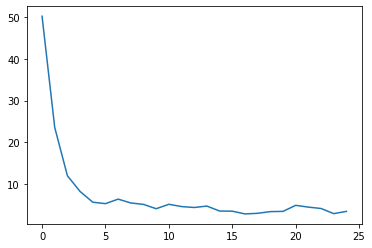

Epoch 1/25
17/17 - 7s - loss: 59.2813 - accuracy: 0.2311 - auc_4: 0.5673 - precision_4: 0.2294 - recall_4: 0.2218 - f1_score: 0.1413 - val_loss: 55.8484 - val_accuracy: 0.1956 - val_auc_4: 0.5361 - val_precision_4: 0.1956 - val_recall_4: 0.1956 - val_f1_score: 0.0988 - 7s/epoch - 409ms/step
Epoch 2/25
17/17 - 6s - loss: 26.3435 - accuracy: 0.2311 - auc_4: 0.5886 - precision_4: 0.2335 - recall_4: 0.2218 - f1_score: 0.1714 - val_loss: 66.2035 - val_accuracy: 0.2066 - val_auc_4: 0.5402 - val_precision_4: 0.2066 - val_recall_4: 0.2066 - val_f1_score: 0.0492 - 6s/epoch - 326ms/step
Epoch 3/25
17/17 - 5s - loss: 13.2096 - accuracy: 0.3327 - auc_4: 0.7100 - precision_4: 0.3313 - recall_4: 0.3068 - f1_score: 0.3549 - val_loss: 32.5017 - val_accuracy: 0.1513 - val_auc_4: 0.5133 - val_precision_4: 0.1513 - val_recall_4: 0.1513 - val_f1_score: 0.0528 - 5s/epoch - 308ms/step
Epoch 4/25
17/17 - 6s - loss: 7.2498 - accuracy: 0.3604 - auc_4: 0.7671 - precision_4: 0.3750 - recall_4: 0.3327 - f1_score:

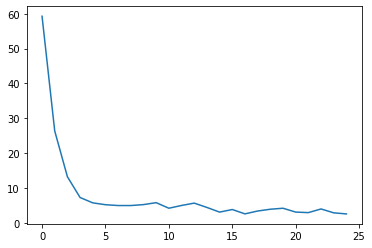

Epoch 1/25
17/17 - 7s - loss: 140.2910 - accuracy: 0.2325 - auc_5: 0.5609 - precision_5: 0.2407 - recall_5: 0.2269 - f1_score: 0.1372 - val_loss: 103.4042 - val_accuracy: 0.1630 - val_auc_5: 0.5228 - val_precision_5: 0.1636 - val_recall_5: 0.1630 - val_f1_score: 0.0680 - 7s/epoch - 412ms/step
Epoch 2/25
17/17 - 6s - loss: 41.8307 - accuracy: 0.2030 - auc_5: 0.5865 - precision_5: 0.2074 - recall_5: 0.1974 - f1_score: 0.1509 - val_loss: 46.6623 - val_accuracy: 0.1370 - val_auc_5: 0.4867 - val_precision_5: 0.1370 - val_recall_5: 0.1370 - val_f1_score: 0.0533 - 6s/epoch - 338ms/step
Epoch 3/25
17/17 - 6s - loss: 25.7139 - accuracy: 0.2232 - auc_5: 0.5888 - precision_5: 0.2274 - recall_5: 0.2177 - f1_score: 0.2128 - val_loss: 56.8774 - val_accuracy: 0.0926 - val_auc_5: 0.4588 - val_precision_5: 0.0929 - val_recall_5: 0.0926 - val_f1_score: 0.0463 - 6s/epoch - 325ms/step
Epoch 4/25
17/17 - 5s - loss: 10.8429 - accuracy: 0.3893 - auc_5: 0.6998 - precision_5: 0.3980 - recall_5: 0.3598 - f1_sco

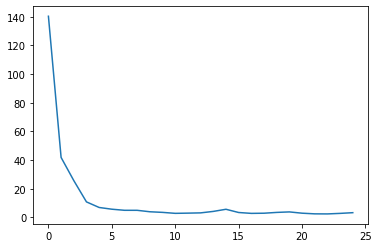

In [11]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_multiclass_body_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_multiclass_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [12]:
y_pred = rcnn_multiclass_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_multiclass_body_model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 26.53% 
Balanced Accuracy: 14.87% 
ROC/AUC: 0.71 
Precision: 0.26 
Recall: 0.22 
F1 score: 0.14


## 2. Unimodal Face Modality (Action Units + Head Pose)

### Dataset

In [13]:
X_train, X_test, y_train, y_test = load_dataset('AUs')
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(782, 1, 350, 25) (782, 7)
(238, 1, 350, 25) (238, 7)


In [14]:
classes = get_class_names('AUs')
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

No Pain               387
LowerBody Mild        157
LowerBody Moderate    100
UpperBody Mild         74
UpperBody Moderate     61
UpperBody Severe        2
LowerBody Severe        1
dtype: int64

In [15]:
nopain, lbmild, lbmod, ubmild, ubmod, ubsevere, lbsevere = np.sum(y, axis=0)
total = nopain + ubmild + lbmod + lbmild + ubmod + ubsevere + lbsevere

weight_for_lbmild = (1 / lbmild) * (total / 2.0)
weight_for_lbmod = (1 / lbmod) * (total / 2.0)
weight_for_nopain = (1 / nopain) * (total / 2.0)
weight_for_ubmild = (1 / ubmild) * (total / 2.0)
weight_for_ubmod = (1 / ubmod) * (total / 2.0)
weight_for_lbsevere = (1 / lbsevere) * (total / 2.0)
weight_for_ubsevere = (1 / ubsevere) * (total / 2.0)

class_weight = {0: weight_for_nopain, 1: weight_for_lbmild, 2: weight_for_lbmod, 3: weight_for_ubmild, 4: weight_for_ubmod, 5: weight_for_ubsevere, 6: weight_for_lbsevere}

print('Weight for class "No Pain": {:.2f}'.format(weight_for_nopain))
print('Weight for class "Lower Body Mild Pain": {:.2f}'.format(weight_for_lbmild))
print('Weight for class "Lower Body Moderate Pain": {:.2f}'.format(weight_for_lbmod))
print('Weight for class "Upper Body Mild Pain": {:.2f}'.format(weight_for_ubmild))
print('Weight for class "Upper Body Moderate Pain": {:.2f}'.format(weight_for_ubmod))
print('Weight for class "Upper Body Severe Pain": {:.2f}'.format(weight_for_ubsevere))
print('Weight for class "Lower Body Severe Pain": {:.2f}'.format(weight_for_lbsevere))

Weight for class "No Pain": 2.49
Weight for class "Lower Body Mild Pain": 3.91
Weight for class "Lower Body Moderate Pain": 391.00
Weight for class "Upper Body Mild Pain": 1.01
Weight for class "Upper Body Moderate Pain": 5.28
Weight for class "Upper Body Severe Pain": 6.41
Weight for class "Lower Body Severe Pain": 195.50


### CNN + Bidirectional LSTM

In [16]:
class CNNLSTM():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=448, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(128, activation='relu'))(flatten)
        dense = Dense(448, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 9s - loss: 126765.0469 - accuracy: 0.1536 - auc_6: 0.5077 - precision_6: 0.1536 - recall_6: 0.1536 - f1_score: 0.0872 - val_loss: 86977.4297 - val_accuracy: 0.0690 - val_auc_6: 0.4566 - val_precision_6: 0.0690 - val_recall_6: 0.0690 - val_f1_score: 0.0186 - 9s/epoch - 543ms/step
Epoch 2/25
17/17 - 7s - loss: 123997.0859 - accuracy: 0.2073 - auc_6: 0.5395 - precision_6: 0.2073 - recall_6: 0.2073 - f1_score: 0.1112 - val_loss: 167254.3594 - val_accuracy: 0.0881 - val_auc_6: 0.4681 - val_precision_6: 0.0881 - val_recall_6: 0.0881 - val_f1_score: 0.0262 - 7s/epoch - 389ms/step
Epoch 3/25
17/17 - 7s - loss: 301477.0312 - accuracy: 0.0845 - auc_6: 0.4659 - precision_6: 0.0845 - recall_6: 0.0845 - f1_score: 0.0281 - val_loss: 126453.4531 - val_accuracy: 0.0920 - val_auc_6: 0.4703 - val_precision_6: 0.0920 - val_recall_6: 0.0920 - val_f1_score: 0.0282 - 7s/epoch - 393ms/step
Epoch 4/25
17/17 - 7s - loss: 143772.9688 - accuracy: 0.0902 - auc_6: 0.4685 - precision_6: 0.0902 - 

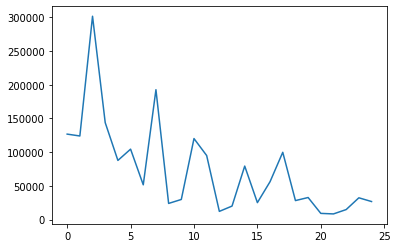

Epoch 1/25
17/17 - 10s - loss: 246001.3125 - accuracy: 0.1094 - auc_7: 0.4737 - precision_7: 0.1094 - recall_7: 0.1094 - f1_score: 0.0664 - val_loss: 30508.2012 - val_accuracy: 0.0038 - val_auc_7: 0.4189 - val_precision_7: 0.0038 - val_recall_7: 0.0038 - val_f1_score: 0.0011 - 10s/epoch - 604ms/step
Epoch 2/25
17/17 - 7s - loss: 114399.2344 - accuracy: 0.0365 - auc_7: 0.4342 - precision_7: 0.0365 - recall_7: 0.0365 - f1_score: 0.0275 - val_loss: 23008.2754 - val_accuracy: 0.0077 - val_auc_7: 0.4211 - val_precision_7: 0.0077 - val_recall_7: 0.0077 - val_f1_score: 0.0034 - 7s/epoch - 439ms/step
Epoch 3/25
17/17 - 10s - loss: 72875.7891 - accuracy: 0.0691 - auc_7: 0.4570 - precision_7: 0.0691 - recall_7: 0.0691 - f1_score: 0.0278 - val_loss: 21594.8945 - val_accuracy: 0.0843 - val_auc_7: 0.4658 - val_precision_7: 0.0843 - val_recall_7: 0.0843 - val_f1_score: 0.0225 - 10s/epoch - 574ms/step
Epoch 4/25
17/17 - 9s - loss: 25934.0508 - accuracy: 0.0825 - auc_7: 0.4646 - precision_7: 0.0707 - 

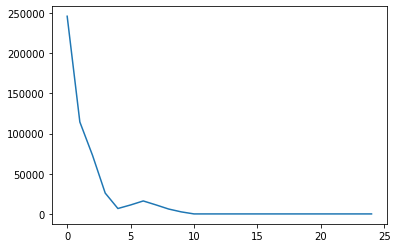

Epoch 1/25
17/17 - 10s - loss: 178410.5625 - accuracy: 0.1839 - auc_8: 0.5244 - precision_8: 0.1839 - recall_8: 0.1839 - f1_score: 0.0944 - val_loss: 29096.6738 - val_accuracy: 0.1577 - val_auc_8: 0.5248 - val_precision_8: 0.1577 - val_recall_8: 0.1577 - val_f1_score: 0.0700 - 10s/epoch - 582ms/step
Epoch 2/25
17/17 - 8s - loss: 336872.0312 - accuracy: 0.2816 - auc_8: 0.5830 - precision_8: 0.2816 - recall_8: 0.2816 - f1_score: 0.0845 - val_loss: 71083.9688 - val_accuracy: 0.0038 - val_auc_8: 0.4189 - val_precision_8: 0.0038 - val_recall_8: 0.0038 - val_f1_score: 0.0022 - 8s/epoch - 465ms/step
Epoch 3/25
17/17 - 7s - loss: 145795.3750 - accuracy: 0.0192 - auc_8: 0.4278 - precision_8: 0.0192 - recall_8: 0.0192 - f1_score: 0.0180 - val_loss: 65342.4141 - val_accuracy: 0.0500 - val_auc_8: 0.4433 - val_precision_8: 0.0500 - val_recall_8: 0.0500 - val_f1_score: 0.0371 - 7s/epoch - 403ms/step
Epoch 4/25
17/17 - 7s - loss: 114102.2188 - accuracy: 0.0709 - auc_8: 0.4557 - precision_8: 0.0709 - 

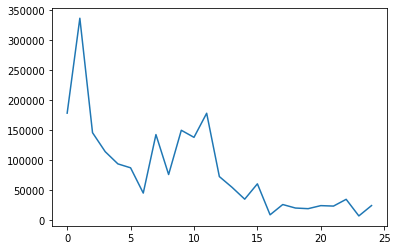

In [17]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_multiclass_face_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_multiclass_face_model.train(X_train, y_train, X_val, y_val, epochs, batch_size, class_weight)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [18]:
y_pred = cnnlstm_multiclass_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_multiclass_face_model.evaluate(X_test, y_test)
cnn_auc.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 9.66% 
Balanced Accuracy: 24.54% 
ROC/AUC: 0.46 
Precision: 0.10 
Recall: 0.10 
F1 score: 0.06


#### RCNN

In [19]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=448, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(448, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results
    
    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 7s - loss: 75.8405 - accuracy: 0.1209 - auc_9: 0.5452 - precision_9: 0.1292 - recall_9: 0.0960 - f1_score: 0.0860 - val_loss: 13.2183 - val_accuracy: 0.1992 - val_auc_9: 0.4486 - val_precision_9: 0.0909 - val_recall_9: 0.0038 - val_f1_score: 0.0543 - 7s/epoch - 386ms/step
Epoch 2/25
17/17 - 5s - loss: 40.1816 - accuracy: 0.1344 - auc_9: 0.5308 - precision_9: 0.1641 - recall_9: 0.1228 - f1_score: 0.1148 - val_loss: 10.7470 - val_accuracy: 0.0690 - val_auc_9: 0.5546 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_f1_score: 0.0189 - 5s/epoch - 305ms/step
Epoch 3/25
17/17 - 5s - loss: 19.6172 - accuracy: 0.1785 - auc_9: 0.6023 - precision_9: 0.2143 - recall_9: 0.1209 - f1_score: 0.1509 - val_loss: 8.8895 - val_accuracy: 0.0153 - val_auc_9: 0.4982 - val_precision_9: 0.3636 - val_recall_9: 0.0153 - val_f1_score: 0.0188 - 5s/epoch - 316ms/step
Epoch 4/25
17/17 - 5s - loss: 32.9272 - accuracy: 0.2534 - auc_9: 0.6221 - precision_9: 0.2339 - recall_9: 0.1881 - f

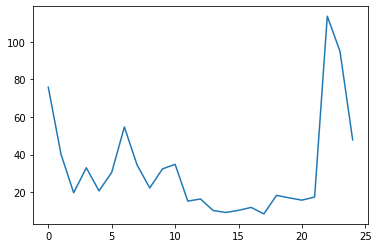

Epoch 1/25
17/17 - 7s - loss: 57.5041 - accuracy: 0.1555 - auc_10: 0.5989 - precision_10: 0.1700 - recall_10: 0.1305 - f1_score: 0.1042 - val_loss: 8.7020 - val_accuracy: 0.2107 - val_auc_10: 0.7175 - val_precision_10: 0.2500 - val_recall_10: 0.0038 - val_f1_score: 0.0550 - 7s/epoch - 394ms/step
Epoch 2/25
17/17 - 5s - loss: 32.9457 - accuracy: 0.3244 - auc_10: 0.6859 - precision_10: 0.3690 - recall_10: 0.2783 - f1_score: 0.1201 - val_loss: 7.3898 - val_accuracy: 0.1111 - val_auc_10: 0.5285 - val_precision_10: 0.2500 - val_recall_10: 0.0038 - val_f1_score: 0.0302 - 5s/epoch - 318ms/step
Epoch 3/25
17/17 - 5s - loss: 16.4134 - accuracy: 0.2207 - auc_10: 0.6068 - precision_10: 0.2381 - recall_10: 0.1248 - f1_score: 0.1188 - val_loss: 4.8094 - val_accuracy: 0.4751 - val_auc_10: 0.7693 - val_precision_10: 0.2500 - val_recall_10: 0.0038 - val_f1_score: 0.0927 - 5s/epoch - 318ms/step
Epoch 4/25
17/17 - 5s - loss: 11.8073 - accuracy: 0.2457 - auc_10: 0.6262 - precision_10: 0.2948 - recall_10:

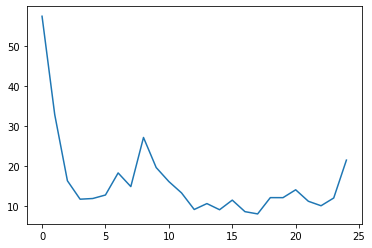

Epoch 1/25
17/17 - 7s - loss: 57.9827 - accuracy: 0.1456 - auc_11: 0.5282 - precision_11: 0.1355 - recall_11: 0.1054 - f1_score: 0.0975 - val_loss: 8.3772 - val_accuracy: 0.0077 - val_auc_11: 0.2478 - val_precision_11: 0.4000 - val_recall_11: 0.0077 - val_f1_score: 0.0152 - 7s/epoch - 421ms/step
Epoch 2/25
17/17 - 5s - loss: 36.5831 - accuracy: 0.1858 - auc_11: 0.4797 - precision_11: 0.2314 - recall_11: 0.1667 - f1_score: 0.1162 - val_loss: 8.8335 - val_accuracy: 0.0692 - val_auc_11: 0.2920 - val_precision_11: 0.2000 - val_recall_11: 0.0038 - val_f1_score: 0.0200 - 5s/epoch - 296ms/step
Epoch 3/25
17/17 - 5s - loss: 25.0721 - accuracy: 0.1341 - auc_11: 0.5117 - precision_11: 0.2406 - recall_11: 0.0977 - f1_score: 0.1030 - val_loss: 5.8603 - val_accuracy: 0.0038 - val_auc_11: 0.3641 - val_precision_11: 0.2000 - val_recall_11: 0.0038 - val_f1_score: 0.0022 - 5s/epoch - 298ms/step
Epoch 4/25
17/17 - 5s - loss: 22.1578 - accuracy: 0.0958 - auc_11: 0.5254 - precision_11: 0.1302 - recall_11:

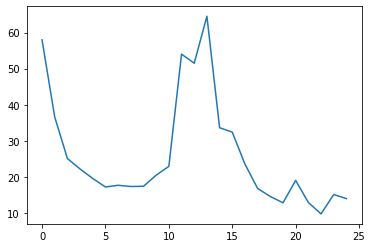

In [20]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_multiclass_face_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_multiclass_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [21]:
y_pred = rcnn_multiclass_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_multiclass_face_model.evaluate(X_test, y_test)
rnn_auc.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 4.62% 
Balanced Accuracy: 16.23% 
ROC/AUC: 0.57 
Precision: 0.71 
Recall: 0.04 
F1 score: 0.04


## 3. Multimodal Early Fusion

### Dataset

In [22]:
X_train, X_test, y_train, y_test = load_fusioned_dataset()
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(782, 1, 350, 60) (782, 7)
(238, 1, 350, 60) (238, 7)


### CNN + Bidirectional LSTM

In [23]:
class CNNLSTM():
    def __init__(self, n_length, n_features, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=448, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(128, activation='relu'))(flatten)
        dense = Dense(448, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 11s - loss: 186272.0000 - accuracy: 0.1209 - auc_12: 0.4878 - precision_12: 0.1209 - recall_12: 0.1209 - f1_score: 0.0710 - val_loss: 71787.6641 - val_accuracy: 0.0920 - val_auc_12: 0.4696 - val_precision_12: 0.0920 - val_recall_12: 0.0920 - val_f1_score: 0.0366 - 11s/epoch - 672ms/step
Epoch 2/25
17/17 - 7s - loss: 43095.0352 - accuracy: 0.0864 - auc_12: 0.4673 - precision_12: 0.0864 - recall_12: 0.0864 - f1_score: 0.0430 - val_loss: 77733.0078 - val_accuracy: 0.0920 - val_auc_12: 0.4703 - val_precision_12: 0.0920 - val_recall_12: 0.0920 - val_f1_score: 0.0281 - 7s/epoch - 437ms/step
Epoch 3/25
17/17 - 7s - loss: 125570.1406 - accuracy: 0.1209 - auc_12: 0.4863 - precision_12: 0.1209 - recall_12: 0.1209 - f1_score: 0.0468 - val_loss: 91661.8516 - val_accuracy: 0.4100 - val_auc_12: 0.6577 - val_precision_12: 0.4100 - val_recall_12: 0.4100 - val_f1_score: 0.0955 - 7s/epoch - 421ms/step
Epoch 4/25
17/17 - 7s - loss: 124721.5859 - accuracy: 0.4376 - auc_12: 0.6734 - prec

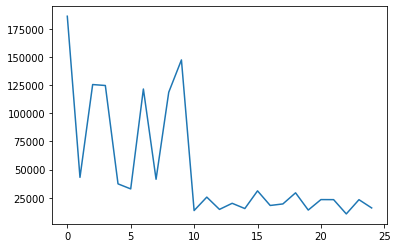

Epoch 1/25
17/17 - 11s - loss: 251560.4375 - accuracy: 0.1363 - auc_13: 0.4980 - precision_13: 0.1363 - recall_13: 0.1363 - f1_score: 0.0801 - val_loss: 45077.7266 - val_accuracy: 0.0843 - val_auc_13: 0.4658 - val_precision_13: 0.0843 - val_recall_13: 0.0843 - val_f1_score: 0.0223 - 11s/epoch - 639ms/step
Epoch 2/25
17/17 - 7s - loss: 115734.6250 - accuracy: 0.1152 - auc_13: 0.4817 - precision_13: 0.1152 - recall_13: 0.1152 - f1_score: 0.0571 - val_loss: 52996.8438 - val_accuracy: 0.0920 - val_auc_13: 0.4703 - val_precision_13: 0.0920 - val_recall_13: 0.0920 - val_f1_score: 0.0347 - 7s/epoch - 435ms/step
Epoch 3/25
17/17 - 7s - loss: 93405.2422 - accuracy: 0.1977 - auc_13: 0.5354 - precision_13: 0.1977 - recall_13: 0.1977 - f1_score: 0.1000 - val_loss: 30337.3867 - val_accuracy: 0.4713 - val_auc_13: 0.6916 - val_precision_13: 0.4713 - val_recall_13: 0.4713 - val_f1_score: 0.0922 - 7s/epoch - 428ms/step
Epoch 4/25
17/17 - 7s - loss: 98986.9922 - accuracy: 0.2630 - auc_13: 0.5716 - preci

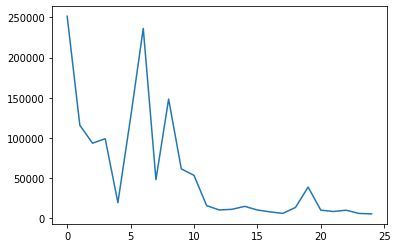

Epoch 1/25
17/17 - 10s - loss: 299757.7812 - accuracy: 0.1686 - auc_14: 0.5159 - precision_14: 0.1686 - recall_14: 0.1686 - f1_score: 0.1215 - val_loss: 56863.9023 - val_accuracy: 0.1115 - val_auc_14: 0.4673 - val_precision_14: 0.1115 - val_recall_14: 0.1115 - val_f1_score: 0.0547 - 10s/epoch - 593ms/step
Epoch 2/25
17/17 - 7s - loss: 304299.8125 - accuracy: 0.2222 - auc_14: 0.5493 - precision_14: 0.2222 - recall_14: 0.2222 - f1_score: 0.1042 - val_loss: 49219.2969 - val_accuracy: 0.4962 - val_auc_14: 0.7061 - val_precision_14: 0.4962 - val_recall_14: 0.4962 - val_f1_score: 0.0947 - 7s/epoch - 427ms/step
Epoch 3/25
17/17 - 7s - loss: 254201.9531 - accuracy: 0.2280 - auc_14: 0.5493 - precision_14: 0.2280 - recall_14: 0.2280 - f1_score: 0.1068 - val_loss: 82572.5000 - val_accuracy: 0.1385 - val_auc_14: 0.4935 - val_precision_14: 0.1385 - val_recall_14: 0.1385 - val_f1_score: 0.0625 - 7s/epoch - 417ms/step
Epoch 4/25
17/17 - 7s - loss: 184110.6719 - accuracy: 0.1073 - auc_14: 0.4781 - pre

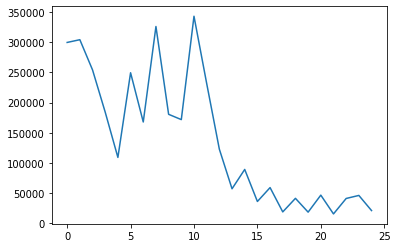

In [24]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = CNNLSTM(n_length, n_features, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, class_weight)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [25]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
cnn_auc.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 28.15% 
Balanced Accuracy: 19.11% 
ROC/AUC: 0.60 
Precision: 0.23 
Recall: 0.15 
F1 score: 0.16


### RCNN

In [26]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=448, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(448, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results
    
    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 7s - loss: 92.3641 - accuracy: 0.1536 - auc_15: 0.5229 - precision_15: 0.1253 - recall_15: 0.1075 - f1_score: 0.1104 - val_loss: 13.0979 - val_accuracy: 0.0766 - val_auc_15: 0.4357 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00 - val_f1_score: 0.0212 - 7s/epoch - 409ms/step
Epoch 2/25
17/17 - 6s - loss: 54.4346 - accuracy: 0.1766 - auc_15: 0.5311 - precision_15: 0.2132 - recall_15: 0.1612 - f1_score: 0.1269 - val_loss: 5.2318 - val_accuracy: 0.4981 - val_auc_15: 0.6970 - val_precision_15: 0.2727 - val_recall_15: 0.0115 - val_f1_score: 0.0960 - 6s/epoch - 325ms/step
Epoch 3/25
17/17 - 6s - loss: 34.3568 - accuracy: 0.2246 - auc_15: 0.5504 - precision_15: 0.2876 - recall_15: 0.2131 - f1_score: 0.1555 - val_loss: 10.3661 - val_accuracy: 0.0115 - val_auc_15: 0.2931 - val_precision_15: 0.2727 - val_recall_15: 0.0115 - val_f1_score: 0.0062 - 6s/epoch - 326ms/step
Epoch 4/25
17/17 - 5s - loss: 20.3053 - accuracy: 0.1651 - auc_15: 0.5064 - precision_15: 0.2613 - 

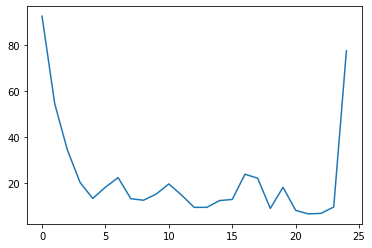

Epoch 1/25
17/17 - 7s - loss: 28.4310 - accuracy: 0.1267 - auc_16: 0.5776 - precision_16: 0.1661 - recall_16: 0.1017 - f1_score: 0.0861 - val_loss: 9.6242 - val_accuracy: 0.1034 - val_auc_16: 0.6620 - val_precision_16: 0.2500 - val_recall_16: 0.0038 - val_f1_score: 0.0350 - 7s/epoch - 422ms/step
Epoch 2/25
17/17 - 6s - loss: 27.7643 - accuracy: 0.1536 - auc_16: 0.6148 - precision_16: 0.1836 - recall_16: 0.1075 - f1_score: 0.0889 - val_loss: 4.2753 - val_accuracy: 0.4751 - val_auc_16: 0.6613 - val_precision_16: 0.2500 - val_recall_16: 0.0038 - val_f1_score: 0.0927 - 6s/epoch - 345ms/step
Epoch 3/25
17/17 - 5s - loss: 26.6088 - accuracy: 0.2821 - auc_16: 0.6121 - precision_16: 0.2927 - recall_16: 0.1843 - f1_score: 0.1578 - val_loss: 5.0814 - val_accuracy: 0.0077 - val_auc_16: 0.5068 - val_precision_16: 0.2500 - val_recall_16: 0.0038 - val_f1_score: 0.0034 - 5s/epoch - 322ms/step
Epoch 4/25
17/17 - 6s - loss: 19.9502 - accuracy: 0.2284 - auc_16: 0.5878 - precision_16: 0.2126 - recall_16:

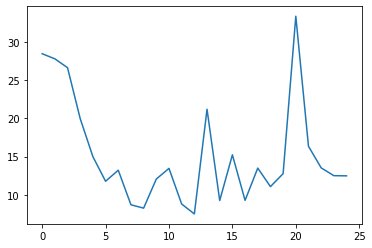

Epoch 1/25
17/17 - 7s - loss: 87.1429 - accuracy: 0.2069 - auc_17: 0.6219 - precision_17: 0.1930 - recall_17: 0.1475 - f1_score: 0.1001 - val_loss: 14.8648 - val_accuracy: 0.4923 - val_auc_17: 0.7608 - val_precision_17: 0.2000 - val_recall_17: 0.0038 - val_f1_score: 0.0945 - 7s/epoch - 419ms/step
Epoch 2/25
17/17 - 6s - loss: 50.8577 - accuracy: 0.1360 - auc_17: 0.5021 - precision_17: 0.1606 - recall_17: 0.0843 - f1_score: 0.0963 - val_loss: 2.9485 - val_accuracy: 0.0154 - val_auc_17: 0.5958 - val_precision_17: 0.6000 - val_recall_17: 0.0115 - val_f1_score: 0.0190 - 6s/epoch - 328ms/step
Epoch 3/25
17/17 - 5s - loss: 25.8067 - accuracy: 0.0900 - auc_17: 0.5519 - precision_17: 0.1365 - recall_17: 0.0881 - f1_score: 0.0750 - val_loss: 5.4022 - val_accuracy: 0.0038 - val_auc_17: 0.5358 - val_precision_17: 0.0038 - val_recall_17: 0.0038 - val_f1_score: 0.0022 - 5s/epoch - 322ms/step
Epoch 4/25
17/17 - 5s - loss: 19.9061 - accuracy: 0.1571 - auc_17: 0.5838 - precision_17: 0.1910 - recall_17

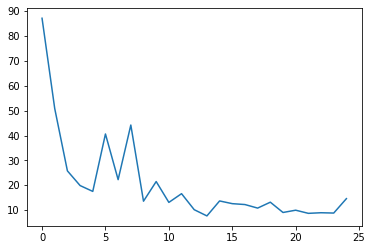

In [27]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = RCNN(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [28]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
rnn_auc.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 3.36% 
Balanced Accuracy: 15.72% 
ROC/AUC: 0.42 
Precision: 0.03 
Recall: 0.03 
F1 score: 0.03


## 4. Multimodal Late Fusion

### Dataset

In [29]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', fusion=True)
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(782, 1, 350, 35) (782, 7)
(238, 1, 350, 35) (238, 7)


In [30]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs')
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(782, 1, 350, 25) (782, 7)
(238, 1, 350, 25) (238, 7)


In [31]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[2], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

### CNN + Bidirectional LSTM

In [32]:
class fusioned_CNNLSTM():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(1, n_length, body_features))
        conv1d_1 = TimeDistributed(Conv1D(filters=448, kernel_size=3, activation='relu'))(input_1)
        maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_1)
        flatten_1 = TimeDistributed(Flatten())(maxpool_1)
        lstm_1 = LSTM(128)(flatten_1)
        dense_1 = Dense(448, activation='relu')(lstm_1)

        input_2 = Input(shape=(1, n_length, face_features))
        conv1d_2 = TimeDistributed(Conv1D(filters=448, kernel_size=3, activation='relu'))(input_2)
        maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_2)
        flatten_2 = TimeDistributed(Flatten())(maxpool_2)
        lstm_2 = LSTM(128)(flatten_2)
        dense_2 = Dense(448, activation='relu')(lstm_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='softmax')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

Epoch 1/25
17/17 - 11s - loss: 8.1708 - accuracy: 0.2361 - auc_18: 0.6499 - precision_18: 0.0000e+00 - recall_18: 0.0000e+00 - f1_score: 0.0928 - val_loss: 1.8495 - val_accuracy: 0.4904 - val_auc_18: 0.7057 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_f1_score: 0.0952 - 11s/epoch - 642ms/step
Epoch 2/25
17/17 - 7s - loss: 8.0770 - accuracy: 0.4875 - auc_18: 0.7102 - precision_18: 0.0000e+00 - recall_18: 0.0000e+00 - f1_score: 0.0939 - val_loss: 1.8500 - val_accuracy: 0.4981 - val_auc_18: 0.6902 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_f1_score: 0.0952 - 7s/epoch - 409ms/step
Epoch 3/25
17/17 - 7s - loss: 7.9505 - accuracy: 0.4914 - auc_18: 0.6960 - precision_18: 0.0000e+00 - recall_18: 0.0000e+00 - f1_score: 0.0990 - val_loss: 1.8890 - val_accuracy: 0.4981 - val_auc_18: 0.6439 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_f1_score: 0.0952 - 7s/epoch - 404ms/step
Epoch 4/25
17/17 - 7s - loss: 7.9078 - accuracy: 0.2706 - auc_

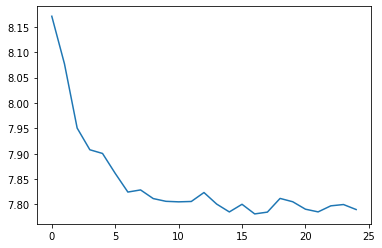

Epoch 1/25
17/17 - 12s - loss: 5.4442 - accuracy: 0.4741 - auc_19: 0.8055 - precision_19: 0.0000e+00 - recall_19: 0.0000e+00 - f1_score: 0.0966 - val_loss: 1.6853 - val_accuracy: 0.4751 - val_auc_19: 0.7861 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00 - val_f1_score: 0.0923 - 12s/epoch - 681ms/step
Epoch 2/25
17/17 - 7s - loss: 5.2704 - accuracy: 0.4453 - auc_19: 0.8095 - precision_19: 0.0000e+00 - recall_19: 0.0000e+00 - f1_score: 0.1080 - val_loss: 1.7360 - val_accuracy: 0.1264 - val_auc_19: 0.7280 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00 - val_f1_score: 0.0381 - 7s/epoch - 423ms/step
Epoch 3/25
17/17 - 8s - loss: 5.2134 - accuracy: 0.1420 - auc_19: 0.7487 - precision_19: 0.0000e+00 - recall_19: 0.0000e+00 - f1_score: 0.0388 - val_loss: 1.7431 - val_accuracy: 0.1149 - val_auc_19: 0.7160 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00 - val_f1_score: 0.0312 - 8s/epoch - 484ms/step
Epoch 4/25
17/17 - 7s - loss: 5.1800 - accuracy: 0.3762 - auc_

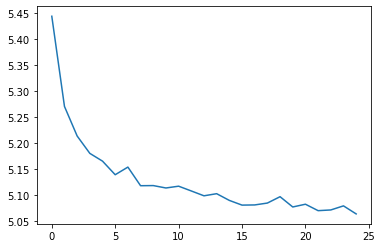

Epoch 1/25
17/17 - 12s - loss: 7.3654 - accuracy: 0.1609 - auc_20: 0.6619 - precision_20: 0.0000e+00 - recall_20: 0.0000e+00 - f1_score: 0.0803 - val_loss: 1.7406 - val_accuracy: 0.5000 - val_auc_20: 0.7833 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.1006 - 12s/epoch - 702ms/step
Epoch 2/25
17/17 - 7s - loss: 7.3795 - accuracy: 0.4904 - auc_20: 0.7746 - precision_20: 0.0000e+00 - recall_20: 0.0000e+00 - f1_score: 0.0968 - val_loss: 1.7496 - val_accuracy: 0.5038 - val_auc_20: 0.7838 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.1011 - 7s/epoch - 424ms/step
Epoch 3/25
17/17 - 7s - loss: 7.2726 - accuracy: 0.4904 - auc_20: 0.7734 - precision_20: 0.0000e+00 - recall_20: 0.0000e+00 - f1_score: 0.0966 - val_loss: 1.7828 - val_accuracy: 0.5038 - val_auc_20: 0.7709 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.1011 - 7s/epoch - 413ms/step
Epoch 4/25
17/17 - 7s - loss: 7.2283 - accuracy: 0.4176 - auc_

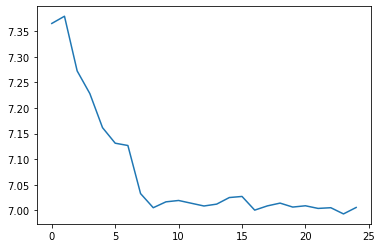

In [33]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_CNNLSTM(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [34]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, body_y_test)
cnn_auc.append(round(auc, 2))
bal_acc = balanced_accuracy_score(body_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 0.42% 
Balanced Accuracy: 14.29% 
ROC/AUC: 0.55 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.00


### RCNN

In [35]:
class fusioned_RCNN():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(1, n_length, body_features))
        conv1d_1 = TimeDistributed(Conv1D(filters=448, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_1)
        bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
        maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_1)
        flatten_1 = Flatten()(maxpool_1)
        dense_1 = Dense(448)(flatten_1)

        input_2 = Input(shape=(1, n_length, face_features))
        conv1d_2 = TimeDistributed(Conv1D(filters=448, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_2)
        bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
        maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_2)
        flatten_2 = Flatten()(maxpool_2)
        dense_2 = Dense(448)(flatten_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='softmax')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

Epoch 1/25
17/17 - 12s - loss: 335.4608 - accuracy: 0.1305 - auc_21: 0.4932 - precision_21: 0.1300 - recall_21: 0.1248 - f1_score: 0.1003 - val_loss: 530.0553 - val_accuracy: 0.0805 - val_auc_21: 0.4625 - val_precision_21: 0.0805 - val_recall_21: 0.0805 - val_f1_score: 0.0291 - 12s/epoch - 699ms/step
Epoch 2/25
17/17 - 9s - loss: 224.0425 - accuracy: 0.2649 - auc_21: 0.5818 - precision_21: 0.2654 - recall_21: 0.2649 - f1_score: 0.1557 - val_loss: 291.4005 - val_accuracy: 0.1839 - val_auc_21: 0.5209 - val_precision_21: 0.1839 - val_recall_21: 0.1839 - val_f1_score: 0.0899 - 9s/epoch - 553ms/step
Epoch 3/25
17/17 - 9s - loss: 191.8999 - accuracy: 0.2610 - auc_21: 0.5827 - precision_21: 0.2610 - recall_21: 0.2610 - f1_score: 0.1657 - val_loss: 316.4179 - val_accuracy: 0.0307 - val_auc_21: 0.4339 - val_precision_21: 0.0307 - val_recall_21: 0.0307 - val_f1_score: 0.0293 - 9s/epoch - 539ms/step
Epoch 4/25
17/17 - 9s - loss: 169.2105 - accuracy: 0.2092 - auc_21: 0.5576 - precision_21: 0.2077 

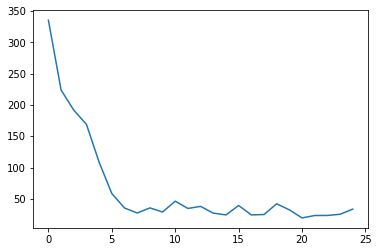

Epoch 1/25
17/17 - 12s - loss: 168.3328 - accuracy: 0.2457 - auc_22: 0.5783 - precision_22: 0.2525 - recall_22: 0.2399 - f1_score: 0.1512 - val_loss: 860.8776 - val_accuracy: 0.1149 - val_auc_22: 0.4837 - val_precision_22: 0.1149 - val_recall_22: 0.1149 - val_f1_score: 0.0296 - 12s/epoch - 733ms/step
Epoch 2/25
17/17 - 11s - loss: 97.7398 - accuracy: 0.2975 - auc_22: 0.6045 - precision_22: 0.2987 - recall_22: 0.2975 - f1_score: 0.1982 - val_loss: 292.7293 - val_accuracy: 0.1226 - val_auc_22: 0.4853 - val_precision_22: 0.1226 - val_recall_22: 0.1226 - val_f1_score: 0.0527 - 11s/epoch - 632ms/step
Epoch 3/25
17/17 - 11s - loss: 61.2895 - accuracy: 0.4165 - auc_22: 0.6855 - precision_22: 0.4181 - recall_22: 0.4165 - f1_score: 0.3078 - val_loss: 123.7820 - val_accuracy: 0.1341 - val_auc_22: 0.4916 - val_precision_22: 0.1341 - val_recall_22: 0.1341 - val_f1_score: 0.0698 - 11s/epoch - 642ms/step
Epoch 4/25
17/17 - 14s - loss: 46.3483 - accuracy: 0.3628 - auc_22: 0.6577 - precision_22: 0.364

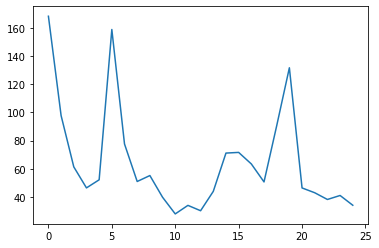

Epoch 1/25
17/17 - 11s - loss: 180.2649 - accuracy: 0.1954 - auc_23: 0.5389 - precision_23: 0.1964 - recall_23: 0.1897 - f1_score: 0.1238 - val_loss: 379.8208 - val_accuracy: 0.1346 - val_auc_23: 0.4952 - val_precision_23: 0.1346 - val_recall_23: 0.1346 - val_f1_score: 0.0341 - 11s/epoch - 636ms/step
Epoch 2/25
17/17 - 9s - loss: 127.6521 - accuracy: 0.3123 - auc_23: 0.6130 - precision_23: 0.3129 - recall_23: 0.3123 - f1_score: 0.3322 - val_loss: 170.2967 - val_accuracy: 0.1500 - val_auc_23: 0.5078 - val_precision_23: 0.1500 - val_recall_23: 0.1500 - val_f1_score: 0.0600 - 9s/epoch - 524ms/step
Epoch 3/25
17/17 - 9s - loss: 65.5107 - accuracy: 0.2510 - auc_23: 0.5945 - precision_23: 0.2495 - recall_23: 0.2490 - f1_score: 0.1990 - val_loss: 74.5779 - val_accuracy: 0.2808 - val_auc_23: 0.5864 - val_precision_23: 0.2808 - val_recall_23: 0.2808 - val_f1_score: 0.1072 - 9s/epoch - 524ms/step
Epoch 4/25
17/17 - 10s - loss: 173.8037 - accuracy: 0.2471 - auc_23: 0.5876 - precision_23: 0.2476 -

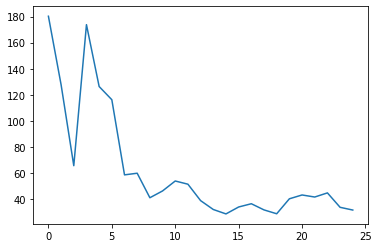

In [36]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_RCNN(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [37]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, body_y_test)
rnn_auc.append(round(auc, 2))
bal_acc = balanced_accuracy_score(body_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 12.61% 
Balanced Accuracy: 17.03% 
ROC/AUC: 0.49 
Precision: 0.13 
Recall: 0.13 
F1 score: 0.08


### Ensemble

In [38]:
class KerasMember():
    def __init__(self, name=None, keras_model=None, train_batches=None,
                 val_batches=None, submission_probs=None, keras_modelpath=None,
                 keras_kwargs={}):
        assert(name is not None)
        self.name = name
        self.model = keras_model
        self.submission_probs = submission_probs
        # Initialize Params
        self.val_probs = None
        self.train_probs = None
        self.val_classes = None
        self.train_classes = None
        if (keras_model is None) and (keras_modelpath is not None):
            self.load_kerasmodel(self.keras_modelpath, self.keras_kwargs)
        if train_batches is not None:
            self._calculate_train_predictions(train_batches)
        if val_batches is not None:
            self._calculate_val_predictions(val_batches)

    def _test_datatuple(self, datatuple):
        assert(len(datatuple) == 2)
        assert(datatuple[0].shape[0] == datatuple[1].shape[0])

    def _calculate_predictions(self, batches):
        if hasattr(batches, 'shuffle'):
            batches.reset()
            batches.shuffle = False
        if type(batches) is tuple:
            self._test_datatuple(batches)
            return self.model.predict(batches[0])
        return self.model.predict_generator(
            batches, steps=(batches.n // batches.batch_size) + 1, verbose=1)

    def _calculate_val_predictions(self, val_batches):
        if type(val_batches) is tuple:
            self.val_classes = val_batches[1]
        elif hasattr(val_batches, 'classes'):
            self.val_classes = np.array(val_batches.classes)
        elif hasattr(val_batches, 'y'):
            self.val_classes = np.array(val_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.val_probs = self._calculate_predictions(val_batches)
        return self.val_probs

    def _calculate_train_predictions(self, train_batches):
        if type(train_batches) is tuple:
            self.train_classes = train_batches[1]
        elif hasattr(train_batches, 'classes'):
            self.train_classes = np.array(train_batches.classes)
        elif hasattr(train_batches, 'y'):
            self.train_classes = np.array(train_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.train_probs = self._calculate_predictions(train_batches)
        return self.train_probs


def _calculate_metric(y_true, y_pred, metric=None):
    if metric is None:
        metric = roc_auc_score
    y_t = y_true
    y_p = y_pred
    if metric == roc_auc_score:
        return metric(y_t, y_p, multi_class='ovo')
    if y_true.ndim > 1:
        y_t = np.argmax(y_true, axis=1)
    if y_pred.ndim > 1:
        y_p = np.argmax(y_pred, axis=1)
    if metric is precision_recall_fscore_support:
        return precision_recall_fscore_support(y_t, y_p, average='macro')
    return metric(y_t, y_p)

class DirichletEnsemble():
    def __init__(self, N=10000, metric=None, maximize=True):
        self.n = N
        self.metric = metric
        if metric is None:
            self.metric = roc_auc_score
        self.maximize = maximize
        # Initialize Parameters:
        self.members = []
        self.bestweights = []
        self.probabilities = None
        self._nmembers = 0
        self.bestscore = float("-inf") if maximize else float("inf")
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.fitted = False

    def add_members(self, members):
        for member in members:
            self.add_member(member)

    def add_member(self, member):
        self.members.append(member)
        self._nmembers += 1

    def fit(self, verbose=False):
        assert(len(self.members) > 1)
        val_classes = self.members[0].val_classes
        best_ensemble_score = float("-inf") if self.maximize else float("inf")
        best_ensemble_accuracy = 0
        best_ensemble_p = 0
        best_ensemble_r = 0
        best_ensemble_f1 = 0
        rsbest = None
        for i in range(self.n):
            rs = np.random.dirichlet(np.ones(self._nmembers), size=1)[0]
            preds = np.sum(np.array([self.members[i].val_probs * rs[i]
                                     for i in range(self._nmembers)]), axis=0)
            ensemble_score = _calculate_metric(val_classes, preds)
            ensemble_accuracy = _calculate_metric(val_classes, preds, accuracy_score)
            ensemble_prf1 = _calculate_metric(val_classes, preds, precision_recall_fscore_support)
            ensemble_p = ensemble_prf1[0]
            ensemble_r = ensemble_prf1[1]
            ensemble_f1 = ensemble_prf1[2]
            max_flag = self.maximize and ensemble_score > best_ensemble_score
            min_flag = not(
                self.maximize) and ensemble_score < best_ensemble_score
            if max_flag or min_flag:
                if verbose:
                    print(ensemble_score, i, rs) 
                best_ensemble_score = ensemble_score
                rsbest = rs
            if ensemble_accuracy > best_ensemble_accuracy:
                if verbose:
                    print(ensemble_accuracy, i, rs) 
                best_ensemble_accuracy = ensemble_accuracy
            if ensemble_p > best_ensemble_p:
                if verbose:
                    print(ensemble_p, i, rs) 
                best_ensemble_p = ensemble_p
            if ensemble_r > best_ensemble_r:
                if verbose:
                    print(ensemble_r, i, rs) 
                best_ensemble_r = ensemble_r
            if ensemble_f1 > best_ensemble_f1:
                if verbose:
                    print(ensemble_f1, i, rs) 
                best_ensemble_f1 = ensemble_f1
        self.bestweights = rsbest
        self.bestscore = best_ensemble_score
        self.accuracy = best_ensemble_accuracy
        self.precision = best_ensemble_p
        self.recall = best_ensemble_r
        self.f1 = best_ensemble_f1

    def predict(self):
        self.probabilities = np.sum(np.array([self.bestweights[i] *
                                              self.members[i].submission_probs
                                              for i in range(self._nmembers)]),
                                    axis=0)
        return self.probabilities
        
    def describe(self):
        for i in range(self._nmembers):
            member = self.members[i]
            text = member.name + " (weight: {:1.4f})".format(self.bestweights[i])
            print(text)
        print("Accuracy: {:1.2f}% - ROC/AUC: {:1.2f} - Precision: {:1.2f} - Recall: {:1.2f} - F1 score: {:1.2f}".format(
            self.accuracy * 100, self.bestscore, self.precision, self.recall, self.f1))
        return self.bestscore

In [39]:
cnnlstm_body_member = KerasMember(name="CNN + Bidirectional LSTM Body Model", keras_model=cnnlstm_multiclass_body_model, train_batches=(body_X_train, body_y_train), val_batches=(body_X_test, body_y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=rcnn_multiclass_body_model, train_batches=(body_X_train, body_y_train), val_batches=(body_X_test, body_y_test))
cnnlstm_face_member = KerasMember(name="CNN + Bidirectional LSTM Face Model", keras_model=cnnlstm_multiclass_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=rcnn_multiclass_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))

In [40]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnnlstm_body_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(cnnlstm_face_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.fit()

In [41]:
e = dirichletEnsemble.describe()
cnn_auc.append(round(e, 2))
rnn_auc.append(0)

CNN + Bidirectional LSTM Body Model (weight: 0.3327)
RCNN Body Model (weight: 0.0715)
CNN + Bidirectional LSTM Face Model (weight: 0.0005)
RCNN Face Model (weight: 0.5953)
Accuracy: 30.67% - ROC/AUC: 0.66 - Precision: 0.25 - Recall: 0.30 - F1 score: 0.20


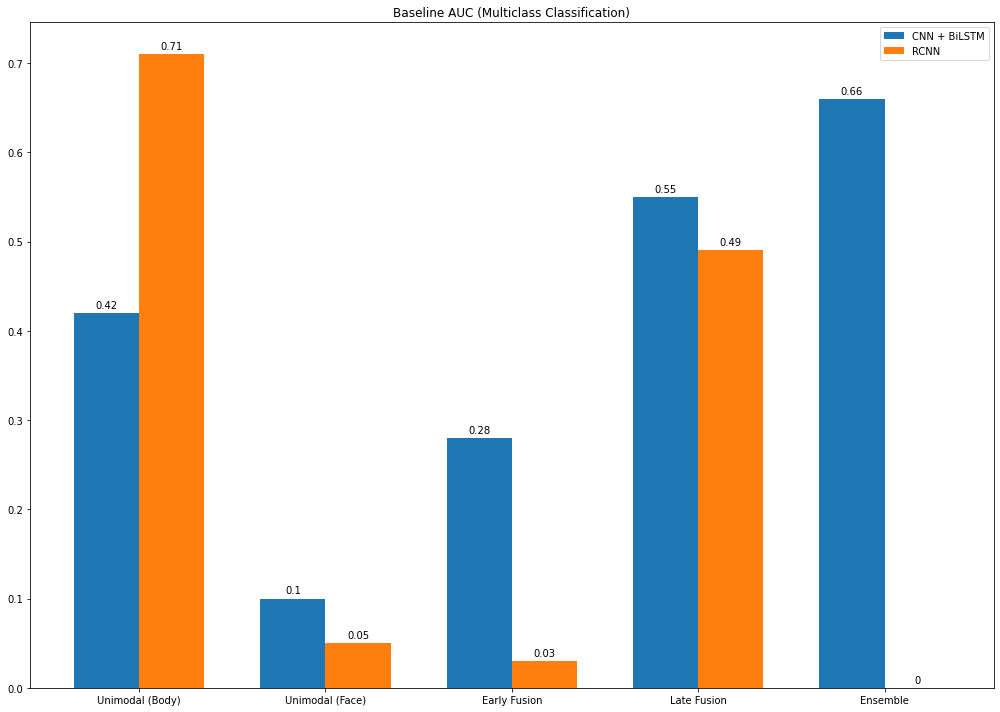

In [42]:
labels = ['Unimodal (Body)', 'Unimodal (Face)', 'Early Fusion', 'Late Fusion', 'Ensemble']
men_means = cnn_auc
women_means = rnn_auc

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, men_means, width, label='CNN + BiLSTM')
rects2 = ax.bar(x + width/2, women_means, width, label='RCNN')

ax.set_title('Baseline AUC (Multiclass Classification)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()